In [1]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
products_df = pd.read_csv('../data/fathur_new_data.csv')

In [3]:
name_df = products_df['product_name']
name_df

0       Celana Tactical Original Big Size Cargo Pria H...
1       Celana Cargo Tactical Panjang Pria HPR Jumbo B...
2       Celana PDL Tactical Ripstop Original Termurah ...
3          CELANA PRIA TACTICAL CARGO PANJANG - Cream, 28
4       Celana Tactical M-Tac Model Terbaru/Cargo/Pria...
                              ...                        
8386    HAIR REMOVER GLUE PEMBERSIH LEM TOUPE LACE WIG...
8387                         Scarlet Fashion Wig A17003#4
8388    Wig Nenek Sihir Grandma Orang Tua Rambut Putih...
8389    Neon Cosplay Wig VALORANT Wanita Man Rambut An...
8390    FYNHA Wig Rambut Palsu Keriting Blow Wavy Kore...
Name: product_name, Length: 8391, dtype: object

In [4]:
name_df = name_df.sample(frac=1).reset_index(drop=True)
name_df

0       sarung tangan motor komine gk 162 / glove komi...
1       KK102 Kaos Kaki Pendek Sport Tebal Olahraga Gy...
2       Unisex Women Tube Scarf Bandana Wear Cycling G...
3       Pita Kaguya Love Is War Aksesoris Costume Cosp...
4       2pcs Telinga Elf Kuping Palsu Elf Ears Aksesor...
                              ...                        
8386    Topi Rimba Gunung Hiking Outdoor Bucket Hat Ta...
8387    RB-P624 Ankle Socks Unisex Kaos Kaki Motif Smi...
8388    24cm x 9cm Hair Holder with Needles Dragging M...
8389    Sepatu Hiking Pantai Air Renang Rafting Mancin...
8390                              Sepatu Costum  Doraemon
Name: product_name, Length: 8391, dtype: object

In [7]:
import re
def clean_product_names(df):
    cleaned_names = []
    for name in df:
        cleaned_name = re.sub(r'[^a-zA-Z\s]', '', name)
        cleaned_name = ' '.join(cleaned_name.split())
        cleaned_name = cleaned_name.lower()
        cleaned_names.append(cleaned_name)
    return cleaned_names

In [8]:
corpus = clean_product_names(name_df)

In [9]:
corpus

['sarung tangan motor komine gk glove komine gk list kuning',
 'kk kaos kaki pendek sport tebal olahraga gym lari men socks black',
 'unisex women tube scarf bandana wear cycling gaiter snoods face',
 'pita kaguya love is war aksesoris costume cosplay wanita dress',
 'pcs telinga elf kuping palsu elf ears aksesoris cosplay',
 'topeng salvador dali topeng money heist topeng la casa de papel',
 'best seller gaiter pelindung kaki naturehike nhhj waterproof',
 'barang terlaris topi wig cosplay pria viral packing aman',
 'sarung tangan motor touch screen smartphone iphone android iglove skul',
 'kaos kaki kerjakaos kaki formalkaos kaki kantor pria anti bakteri',
 'banyak dicari ex round hat hiking hat topi gunung outdoor bucket grey',
 'kemeja safety tactical w tac termurah lengan pendek kemeja tactical navy m',
 'topi rimba hitam',
 'tenda cloud up t naturehike nhtt upgrade version orange',
 'topi rimba premium topi rimba gunung outdoor adventure hiking camping',
 'emergency survival kit m

In [10]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

In [11]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):

		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

# Convert the label into one-hot arrays
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [12]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['sarung', 'tangan', 'motor', 'komine', 'gk', 'glove', 'komine', 'gk', 'list', 'kuning']
[11, 9, 90, 1135, 1017, 95, 1135, 1017, 1018, 254]


In [13]:
# Build the model
model = Sequential([
          Embedding(total_words, 128, input_length=max_sequence_len-1),
          Bidirectional(LSTM(200)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 128)           1024000   
                                                                 
 bidirectional (Bidirection  (None, 400)               526400    
 al)                                                             
                                                                 
 dense (Dense)               (None, 8000)              3208000   
                                                                 
Total params: 4758400 (18.15 MB)
Trainable params: 4758400 (18.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.9:
            self.model.stop_training = True
            print("\nAkurasi pelatihan telah mencapai 90%!")
callbacks = myCallback()

# Train the model
history = model.fit(xs, ys, epochs=100, batch_size=64, callbacks=[callbacks])

Epoch 1/100


1073/1073 [==============================] - 142s 125ms/step - loss: 6.5618 - acc: 0.0775
Epoch 2/100
1073/1073 [==============================] - 145s 135ms/step - loss: 5.2437 - acc: 0.1717
Epoch 3/100
1073/1073 [==============================] - 137s 128ms/step - loss: 4.5320 - acc: 0.2247
Epoch 4/100
1073/1073 [==============================] - 142s 132ms/step - loss: 3.9872 - acc: 0.2721
Epoch 5/100
1073/1073 [==============================] - 138s 129ms/step - loss: 3.5356 - acc: 0.3147
Epoch 6/100
1073/1073 [==============================] - 145s 135ms/step - loss: 3.1476 - acc: 0.3585
Epoch 7/100
1073/1073 [==============================] - 142s 132ms/step - loss: 2.8104 - acc: 0.4076
Epoch 8/100
1073/1073 [==============================] - 146s 136ms/step - loss: 2.5142 - acc: 0.4554
Epoch 9/100
1073/1073 [==============================] - 137s 127ms/step - loss: 2.2577 - acc: 0.4998
Epoch 10/100
1073/1073 [==============================] - 143s 133ms/step - loss

In [17]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [18]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

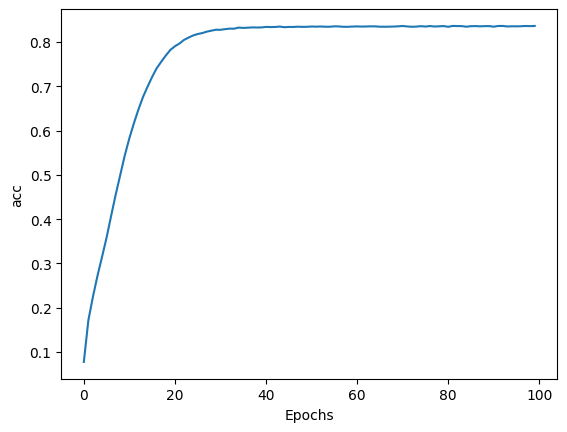

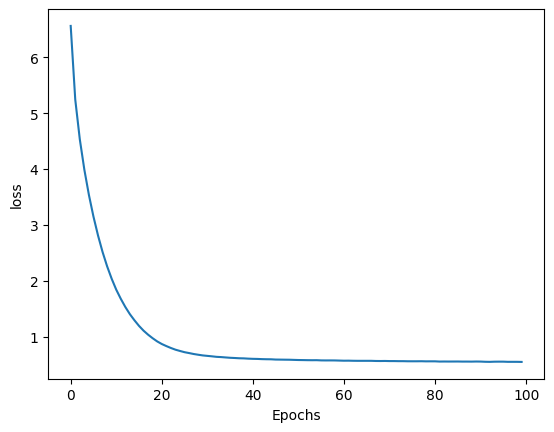

In [19]:
plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

In [27]:
def generate_text(model, tokenizer, seed_text, max_sequence_len, next_words=2):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [31]:
test_1 = generate_text(model, tokenizer, 'tenda', max_sequence_len, 2)
test_2 = generate_text(model, tokenizer, 'hiking', max_sequence_len, 3)
test_3 = generate_text(model, tokenizer, 'cosplay', max_sequence_len, 1)
test_4 = generate_text(model, tokenizer, 'kostum', max_sequence_len, 4)
test_5 = generate_text(model, tokenizer, 'wig', max_sequence_len, 5)

print(test_1)
print(test_2)
print(test_3)
print(test_4)
print(test_5)

tenda lipat matic
hiking trekking pole tongkat
cosplay topeng
kostum anak unicorn jumpsuit import
wig rambut palsu wanita fiber fb


In [32]:
model.save("new_saved_model")

INFO:tensorflow:Assets written to: new_saved_model\assets


INFO:tensorflow:Assets written to: new_saved_model\assets
